Code Organization:
Section 1: PPO implementation.
Section 2: Importing and training DQN and A2C.
Section 3: Benchmarking and visualizing results.
Section 4: PPO hyperparameter tuning.
Prepare for Paper Figures:
Generate clean, labeled plots and tables.
Include insights about why PPO’s performance changes with certain hyperparameters.

In [35]:
# Importing necessary libraries
import gym  
import numpy as np  
import torch  
import torch.nn as nn  
import torch.optim as optim  

# Set up the environment
env = gym.make("LunarLander-v2", render_mode="human")  

In [36]:
# Define the policy network (actor)
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        # A simple 2-layer fully connected network
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)  # Output probabilities


# Define the value network (critic)
class ValueNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ValueNetwork, self).__init__()
        # A simple 2-layer fully connected network
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)  # Output the value (scalar)

In [37]:
# Function to compute the advantage
def compute_advantages(rewards, values, gamma=0.99, lam=0.95):
    advantages = []
    gae = 0  # Generalized Advantage Estimation
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + (gamma * values[t + 1] if t < len(rewards) - 1 else 0) - values[t]
        gae = delta + gamma * lam * gae
        advantages.insert(0, gae)
    return torch.tensor(advantages, dtype=torch.float32)

def collect_trajectory(env, policy, value, max_steps=1000):
    states, actions, rewards, values, log_probs = [], [], [], [], []
    state = env.reset()  # Reset the environment
    if isinstance(state, tuple):  # Handle case where reset() returns (obs, info)
        state = state[0]

    for _ in range(max_steps):
        # Convert state to tensor and add batch dimension
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        # Get action distribution from the policy network
        with torch.no_grad():  # Disable gradients for action selection
            dist = policy(state_tensor)
            action = torch.distributions.Categorical(dist).sample()
            log_prob = torch.distributions.Categorical(dist).log_prob(action)

        # Take a step in the environment
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated  # Combine termination flags

        # Save the experience
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        values.append(value(state_tensor).item())
        log_probs.append(log_prob)

        state = next_state  # Update state
        if done:
            break

    # Compute the value for the final state
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    values.append(value(state_tensor).item())

    return states, actions, rewards, values, log_probs

In [ ]:
# Hyperparameters
epochs = 50
steps_per_epoch = 4000
gamma = 0.99
lam = 0.95
clip_ratio = 0.2
policy_lr = 3e-4
value_lr = 1e-3

# Initialize networks
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n

policy = PolicyNetwork(obs_dim, act_dim)
value = ValueNetwork(obs_dim)

policy_optimizer = optim.Adam(policy.parameters(), lr=policy_lr)
value_optimizer = optim.Adam(value.parameters(), lr=value_lr)

# Training loop
for epoch in range(epochs):
    # Collect trajectories
    states, actions, rewards, values, log_probs = collect_trajectory(env, policy, value)

    # Compute advantages and discounted rewards
    advantages = compute_advantages(rewards, values, gamma, lam)
    discounted_rewards = torch.tensor(rewards, dtype=torch.float32)

    # Normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # Update policy network
    for _ in range(4):  # Multiple passes over data
        for i in range(len(states)):
            # Convert state to tensor and add batch dimension
            state = torch.tensor(states[i], dtype=torch.float32).unsqueeze(0)
            action = actions[i]
            log_prob = log_probs[i]
            advantage = advantages[i]

            # Calculate new log probabilities
            dist = policy(state)
            new_log_prob = torch.distributions.Categorical(dist).log_prob(action)

            # Policy loss (clipped objective)
            ratio = torch.exp(new_log_prob - log_prob)
            clipped_ratio = torch.clamp(ratio.clone(), 1 - clip_ratio, 1 + clip_ratio)
            policy_loss = -torch.min(ratio * advantage, clipped_ratio * advantage).mean()

            # Backpropagate
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()


    # Update value network
    for i in range(len(states)):
        # Convert state to tensor for value network
        state = torch.tensor(states[i], dtype=torch.float32).unsqueeze(0)
        reward = discounted_rewards[i]

        # Value loss
        value_loss = ((value(state) - reward) ** 2).mean()
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs} completed.")

    if (epoch + 1) % 10 == 0:  # Render every 10 epochs
        state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    done = False
    while not done:
        state_tensor = torch.as_tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            dist = policy(state_tensor)
            action = torch.distributions.Categorical(dist).sample().item()
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        env.render()  # Render the environment

Epoch 1/50 completed.
Epoch 2/50 completed.
Epoch 3/50 completed.
Epoch 4/50 completed.
Epoch 5/50 completed.
Epoch 6/50 completed.


Epoch 1/50, Total Reward: -296.2168234599658
Epoch 2/50, Total Reward: -296.2168234599658
Epoch 3/50, Total Reward: -296.2168234599658
Epoch 4/50, Total Reward: -296.2168234599658
Epoch 5/50, Total Reward: -296.2168234599658
Epoch 6/50, Total Reward: -296.2168234599658
Epoch 7/50, Total Reward: -296.2168234599658
Epoch 8/50, Total Reward: -296.2168234599658
Epoch 9/50, Total Reward: -296.2168234599658
Epoch 10/50, Total Reward: -296.2168234599658
Epoch 11/50, Total Reward: -296.2168234599658
Epoch 12/50, Total Reward: -296.2168234599658
Epoch 13/50, Total Reward: -296.2168234599658
Epoch 14/50, Total Reward: -296.2168234599658
Epoch 15/50, Total Reward: -296.2168234599658
Epoch 16/50, Total Reward: -296.2168234599658
Epoch 17/50, Total Reward: -296.2168234599658
Epoch 18/50, Total Reward: -296.2168234599658
Epoch 19/50, Total Reward: -296.2168234599658
Epoch 20/50, Total Reward: -296.2168234599658
Epoch 21/50, Total Reward: -296.2168234599658
Epoch 22/50, Total Reward: -296.21682345996

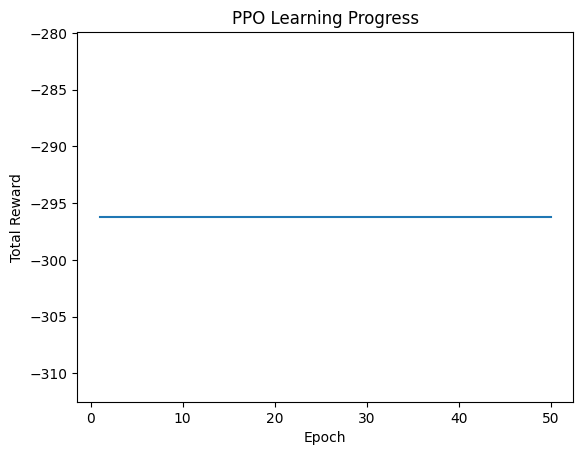

In [29]:
import matplotlib.pyplot as plt

epoch_rewards = []  # Store rewards for each epoch
for epoch in range(epochs):
    total_reward = sum(rewards)  # Compute total reward for this epoch
    epoch_rewards.append(total_reward)
    print(f"Epoch {epoch + 1}/{epochs}, Total Reward: {total_reward}")

# After training, plot the rewards
plt.plot(range(1, epochs + 1), epoch_rewards)
plt.xlabel("Epoch")
plt.ylabel("Total Reward")
plt.title("PPO Learning Progress")
plt.show()

In [ ]:
from stable_baselines3 import DQN

dqn_model = DQN("MlpPolicy", env, verbose=1)
dqn_model.learn(total_timesteps=50000)

In [ ]:
from stable_baselines3 import A2C

a2c_model = A2C("MlpPolicy", env, verbose=1)
a2c_model.learn(total_timesteps=50000)

In [ ]:
def evaluate_model(env, model, num_episodes=10):
    total_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(state, deterministic=True)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
        total_rewards.append(total_reward)
    return total_rewards

In [ ]:
ppo_rewards = evaluate_model(env, policy)  # For PPO
dqn_rewards = evaluate_model(env, dqn_model)  # For DQN
a2c_rewards = evaluate_model(env, a2c_model)  # For A2C

print(f"PPO Average Reward: {np.mean(ppo_rewards)}")
print(f"DQN Average Reward: {np.mean(dqn_rewards)}")
print(f"A2C Average Reward: {np.mean(a2c_rewards)}")

methods = ["PPO", "DQN", "A2C"]
avg_rewards = [np.mean(ppo_rewards), np.mean(dqn_rewards), np.mean(a2c_rewards)]

plt.bar(methods, avg_rewards)
plt.xlabel("Algorithm")
plt.ylabel("Average Reward")
plt.title("Performance Comparison")
plt.show()